# Imports

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, SPARQLExceptions
from itertools import combinations
from networkx.algorithms.matching import max_weight_matching
from pathlib import Path
from urllib import error

import itertools
import time
import warnings

warnings.filterwarnings('ignore')

# Constants

In [3]:
NODE = "wd:Q15149637"
NODE_URL = "http://www.wikidata.org/entity/Q15149637"
NODE_PDF_FILE = f"{NODE.split(':')[1]}.pdf"
NODE_PKL_FILE = f"{NODE.split(':')[1]}.pkl"
NODE_HTML_FILE = f"{NODE.split(':')[1]}.html"

# Building the graph

In [4]:
def rdf_graph_cleaner(rdf_graph):
     # Produces a dataframe based on the RDFlib graph
    query_df = pd.DataFrame(rdf_graph, columns=["Subject", "Property", "Value"])
    # Cleaning unwanted wrappings around our objects
    query_df["Subject"] = query_df["Subject"].str.replace("rdflib.term.URIRef", "")
    query_df["Value"] = query_df["Value"].str.replace("rdflib.term.URIRef", "")
    query_df["Property"] = query_df["Property"].str.replace("rdflib.term.URIRef", "")
    discard_properties = ["P921", "P2860", "http://schema.org/about"]  # Properties to discard
    discard_sub_obj = ["/statement/"]  #  Subjects and Objects to discard
    query_df = query_df[~query_df.Property.str.contains('|'.join(discard_properties))]
    query_df = query_df[~query_df.Subject.str.contains('|'.join(discard_sub_obj))]
    query_df = query_df[~query_df.Value.str.contains('|'.join(discard_sub_obj))]
    # Convert dataframe to a networkx graph
    nx_graph = nx.from_pandas_edgelist(query_df, "Subject", "Value", edge_attr="Property")

    return nx_graph

In [5]:
def query(input_node: str) -> nx.Graph:
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(f"""
                        CONSTRUCT {{ 
                            {input_node} ?p1 ?outgoing.
                            ?ingoing ?p2 {input_node}.
                        }} 
                        WHERE {{
                            OPTIONAL {{
                                {input_node} ?p1 ?outgoing.
                                FILTER(isURI(?outgoing))
                            }}
                            OPTIONAL {{
                                ?ingoing ?p2 {input_node}.
                            }}
                            MINUS{{?ingoing wdt:P31 wd:Q5}}
                            MINUS{{wd:Q5 wdt:P31 ?outgoing}}
                        }}
                    """)
    query_result = sparql.queryAndConvert() # Produces a RDFlib Graph object

    return rdf_graph_cleaner(query_result)

In [6]:
def recursive_graph_builder():
    nx_graph = query(NODE)
    for node in nx_graph.neighbors(NODE_URL):
        try:
            neighbor_nx = query("<"+node+">")
            nx_graph = nx.compose(nx_graph, neighbor_nx)
        except (error.HTTPError):
            time.sleep(30)
            pass

        try:
            for n in neighbor_nx.neighbors(node):
                neighbors_neighbor_nx = query("<"+n+">")
                nx_graph = nx.compose(nx_graph, neighbors_neighbor_nx)
        except (KeyError, nx.NetworkXError):
            pass
        except (SPARQLExceptions.EndPointInternalError, error.HTTPError):
            time.sleep(30)
            pass

    return nx_graph

In [7]:
pd_graph_path = Path.cwd() / "rdf_graphs" / NODE_PKL_FILE
if pd_graph_path.is_file():
    df = pd.read_pickle(pd_graph_path)
    input_node = nx.from_pandas_edgelist(df, edge_attr=True)
else:
    input_node = recursive_graph_builder()
    df = nx.to_pandas_edgelist(input_node)
    df.to_pickle(pd_graph_path)
print(f"Initial Graph Size: nodes({len(input_node.nodes())}), edges({len(input_node.edges())})")

Initial Graph Size: nodes(2325), edges(2493)


In [8]:
df = pd.DataFrame({'node': np.unique(df[['source', 'target']].values)})
df["identifier"] = 0
df["rolesim"] = 0
df["neighborhood"] = 0
df["score"] = 0
df

,node,identifier,rolesim,neighborhood,score
0,http://babelnet.org/rdf/s00065877n,0,0,0,0
1,http://babelnet.org/rdf/s01632322n,0,0,0,0
2,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0
3,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0
4,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0
...,...,...,...,...,...
2320,https://id.loc.gov/authorities/names/sh85110354,0,0,0,0
2321,https://id.loc.gov/authorities/names/sh86003392,0,0,0,0
2322,https://libris.kb.se/hftwzrl14nx7948,0,0,0,0
2323,https://livedata.bibsys.no/authority/90098248,0,0,0,0


# Identifier heuristic

In [9]:
def identifier(graph: nx.Graph, node: str, df: pd.DataFrame) -> pd.DataFrame:
    GND_IDENTIFIER = "http://www.wikidata.org/prop/direct-normalized/P227"
    for item in graph.neighbors(node):
        prop = graph[node][item]["Property"]
        if prop == GND_IDENTIFIER: 
            for item_neighbor in graph.neighbors(item):
                neigh_prop = graph[item][item_neighbor]["Property"]
                if item_neighbor == node:
                    continue
                if prop == neigh_prop:
                    df.loc[df.node == item_neighbor, 'identifier'] = 1

    return df

In [10]:
df = identifier(input_node, NODE_URL, df)
df.loc[df.identifier == 1]

,node,identifier,rolesim,neighborhood,score
1237,http://www.wikidata.org/entity/Q336938,1,0,0,0


# Neighborhood heuristic

In [11]:
def normalize_dict(neighbor_dict: dict, degree: int) -> dict:
    for key, val in neighbor_dict.items():
        neighbor_dict[key] = val / degree
    return neighbor_dict

In [12]:
def common_neighbors(graph: nx.Graph, node: str, df: pd.DataFrame) -> pd.DataFrame:
    nodes_to_skip = ["http://www.w3.org/ns/lemon/ontolex#LexicalSense", "http://wikiba.se/ontology#BestRank", "http://wikiba.se/ontology#NormalRank"]
    node_dict = {}

    for item in graph.neighbors(node):
        for neighbor in graph.neighbors(item):
            if neighbor == node or neighbor in nodes_to_skip or item == node:
                continue
            jaccard_similarity = nx.jaccard_coefficient(graph, [(neighbor, node)])
            node_dict[neighbor] = list(jaccard_similarity)[0][2]
            
    for key, val in node_dict.items():
        df.loc[df.node == key, 'neighborhood'] = val
    return df

In [13]:
df = common_neighbors(input_node, NODE_URL, df)
df.sort_values(by=['neighborhood'], ascending=False).head(10)

,node,identifier,rolesim,neighborhood,score
1592,http://www.wikidata.org/entity/Q69428825,0,0,0.428571,0
1591,http://www.wikidata.org/entity/Q69428534,0,0,0.428571,0
1793,http://www.wikidata.org/entity/Q84026278,0,0,0.285714,0
1750,http://www.wikidata.org/entity/Q815588,0,0,0.285714,0
621,http://www.wikidata.org/entity/Q1418023,0,0,0.250000,0
1422,http://www.wikidata.org/entity/Q5239054,0,0,0.166667,0
1237,http://www.wikidata.org/entity/Q336938,1,0,0.148148,0
936,http://www.wikidata.org/entity/Q2133472,0,0,0.142857,0
1807,http://www.wikidata.org/entity/Q846785,0,0,0.142857,0
951,http://www.wikidata.org/entity/Q214881,0,0,0.142857,0


# RoleSim

#### Iceberg pruning constants

In [14]:
THETA = 0.6
ALPHA = 0.4
BETA = 0.3
THETA_BAR = (THETA - BETA)/(1 - BETA)

#### sort_nodes_by_degree

In [15]:
def sort_nodes_by_degree(graph):
    """Sorts nodes in graph by degree.

    Args:
        graph (nx.Graph): The graph which is build around a given input node.

    Returns:
        np.array: Nodes sorted by degree in descending order.
    """
    unsorted_degrees = []
    unsorted_nodes = []

    for node in list(graph.nodes):
        unsorted_nodes.append(node)
        unsorted_degrees.append(graph.degree(node))

    sorted_node_degree_by_index = np.argsort(-np.array(unsorted_degrees), kind ='mergesort')
    sorted_nodes_by_degree = np.array(unsorted_nodes)[sorted_node_degree_by_index]

    return sorted_nodes_by_degree

#### sort_neighborhood_degree

In [16]:
def sort_neighborhood_degree(sorted_nodes, graph):
    """Sorts each nodes neighbors by degree.

    Args:
        sorted_nodes (np.array): Nodes in graph sorted by their degree.
        graph (nx.Graph): The graph which is build around a given input node.

    Returns:
        dict: The dict keys are sorted by each nodes degree in descending order and their neighbors degree sorted descending as well as the node name as values.
    """
    neighbor_degree_sorted_dict = {}

    for node in sorted_nodes:
        neighbors = list(graph.neighbors(node))
        neighbor_degrees = [graph.degree(n) for n in neighbors]
        sorted_neighbor_degrees_by_index = np.argsort(neighbor_degrees, kind ='mergesort')
        sorted_neighbors = np.array(neighbors)[sorted_neighbor_degrees_by_index]
        sorted_neighbor_degrees = np.array(neighbor_degrees)[sorted_neighbor_degrees_by_index]
        neighbor_degree_sorted_dict[node] = (sorted_neighbors, sorted_neighbor_degrees)

    return neighbor_degree_sorted_dict

#### get_maximal_matching_weight

In [17]:
def get_maximal_matching_weight(graph, node_u, node_v, neighbor_degree_sorted_dict):
    """Build a subgraph based on the neighbors of a node u and a node v and the edges between these neighbors.

    Args:
        graph (nx.Graph): The graph which is build around a given input node.
        node_u (str): A node existing in the variable graph.
        node_v (str): A node existing in the variable graph.
        neighbor_degree_sorted_dict (dict): A dict where keys are sorted by each nodes degree. Values are the nodes neighbors degree sorted as well as the node name.

    Returns:
        set: A maximal matching of the graph.
    """
    neighbors_u = list(neighbor_degree_sorted_dict[node_u][0])
    neighbors_v = list(neighbor_degree_sorted_dict[node_v][0])
    combined = [neighbors_u, neighbors_v]
    all_possible_edges = list(itertools.product(*combined))

    subgraph = nx.Graph()
    for edge in all_possible_edges:
        if graph.has_edge(*edge):
            subgraph.add_edge(*edge)
       
    # A matching is a subset of edges in which no node occurs more than once. 
    # The weight of a matching is the sum of the weights of its edges. 
    # A maximal matching cannot add more edges and still be a matching. 
    # The cardinality of a matching is the number of matched edges.
    weight = max_weight_matching(subgraph)

    return weight

#### Permutation

In [18]:
def permutations(sorted_node_list):
    """Generates every possible pair of combinations from a list of values

    Args:
        sorted_node_list (np.array): An array of nodes in graph sorted by their degree respectively

    Returns:
        tuple: Returns pairs of nodes in every possible combinations where order does not matter ( (u, v) = (v, u) )
    """
    comb = combinations(sorted_node_list, 2)
    return comb

#### Creating Initial Similarity Matrix using Pruned Combinations

In [19]:
def iceberg_pruning(comb, graph, neighbor_degree_sorted_dict):
    """Generates a subgraph based on rules that determines wether or not an edge should be added or discarded.

    Args:
        comb (tuple): Every node pairs from the variable graph.
        graph (nx.Graph): The graph which is build around a given input node.
        neighbor_degree_sorted_dict (dict): A dict where keys are sorted by each nodes degree. Values are the nodes neighbors degree sorted as well as the node name.

    Returns:
        nx.Graph: A subgraph of the input graph containing nodes and edges that is not pruned by a treshold.
    """
    pruned_by_one = 0
    pruned_by_two = 0
    pruned_by_three = 0

    similarity_temp_graph_iceberg = nx.Graph()

    # Begin the process of pruning using the Iceberg concept
    for i in list(comb):
        node_u = i[0]
        node_v = i[1]

        # Rule 1
        if (THETA_BAR*graph.degree(node_u) > graph.degree(node_v)) or (graph.degree(node_v) > graph.degree(node_u)):
            pruned_by_one += 1
            continue
        else :
            # Rule 3
            neighbor_1_degree_u = neighbor_degree_sorted_dict[node_u][1][0]
            neighbor_1_degree_v = neighbor_degree_sorted_dict[node_v][1][0]
            m11 = (1 - BETA) * (min(neighbor_1_degree_u, neighbor_1_degree_v) / max(neighbor_1_degree_u, neighbor_1_degree_v)) + BETA
            if neighbor_1_degree_v <= neighbor_1_degree_u and ((graph.degree(node_v) - 1 + m11) < (THETA_BAR*graph.degree(node_u))):
                pruned_by_three += 1
                continue

        # Rule 2
        maximal_matching_weight = len(get_maximal_matching_weight(graph, node_u, node_v, neighbor_degree_sorted_dict))
        if maximal_matching_weight >= THETA_BAR*graph.degree(node_u):
            similarity_initial_value = (1 - BETA) * (maximal_matching_weight/graph.degree(node_u)) + BETA
            similarity_temp_graph_iceberg.add_edge(node_u, node_v, weight=similarity_initial_value)
        else:
            pruned_by_two += 1

    print(pruned_by_one, ' nodes were pruned by rule 1.')
    print(pruned_by_two, ' nodes were pruned by rule 2.')
    print(pruned_by_three, ' nodes were pruned by rule 3.')

    return similarity_temp_graph_iceberg

#### Auxiliary

In [20]:
def auxiliary(graph, pruned_iceberg_graph):
    """Extends on a pruned graph using the iceberg model and adds edges with weights for node pairs that does not exist in the pruned graph.

    Args:
        graph (nx.Graph): The graph which is build around a given input node.
        pruned_iceberg_graph (nx.Graph): A subgraph of the input graph containing nodes and edges that is not pruned by a treshold theta.

    Returns:
        nx.Graph: A graph based on the pruned graph, but with additional edges between pairs of nodes with no existing edge. The additional edges includes weights.
        list: A list of nodes from the pruned graph.
    """
    final_similarity_iceberg_graph = nx.Graph(pruned_iceberg_graph)
    list_of_nodes_selected = list(final_similarity_iceberg_graph.nodes)

    for edgepair in combinations(list_of_nodes_selected, 2):
        u = edgepair[0]
        v = edgepair[1]
        if final_similarity_iceberg_graph.has_edge(*edgepair):
            continue
        else:
            degree_u = graph.degree(u)
            degree_v = graph.degree(v)
            weight_of_edgepair = (ALPHA * (1 - BETA) * (min(degree_u, degree_v) / max(degree_u, degree_v))) + BETA
            final_similarity_iceberg_graph.add_edge(*edgepair, weight=weight_of_edgepair)

    return final_similarity_iceberg_graph, list_of_nodes_selected

#### All maximal matching

In [21]:
def all_maximal_matchings(subgraph):
    """Generates all possible maximal matchings which are sets of tuples containing node pairs (or edges).

    Args:
        subgraph (nx.Graph): A subgraph based on the neighborhood of two nodes u and v. All nodes are connected to eachother.

    Returns:
        list: List of all possible maximal matchings.
    """
    maximal_matchings = []
    partial_matchings = [{(u,v)} for (u,v) in subgraph.edges()]
    
    while partial_matchings:
        # Get current partial matching
        m = partial_matchings.pop()
        nodes_m = set(itertools.chain(*m))
        
        extended = False
        for (u,v) in subgraph.edges():
            if u not in nodes_m and v not in nodes_m:
                extended = True
                # copy m, extend it and add it to the list of partial matchings
                m_extended = set(m)
                m_extended.add((u,v))
                partial_matchings.append(m_extended)

        if not extended and m not in maximal_matchings:
            maximal_matchings.append(m)
    print(f"LOOK AT ME: {maximal_matchings}")
    return maximal_matchings

#### Convergence

In [22]:
def check_if_converged_graph(current_iteration, previous_iteration):
    """Checks if there graph has converged between two iterations.

    Args:
        current_iteration (nx.Graph): A graph with the current calculated weights.
        previous_iteration (_type_): A graph with the previous iteration of calculated weights.

    Returns:
        bool: Returns True if the graph has converged else False.
    """
    # Get the total of all edge weights
    current_sum = current_iteration.size(weight='weight')
    previous_sum = previous_iteration.size(weight='weight')
    diff = np.fabs(current_sum - previous_sum)  # The absolute value of the difference
    # Checks if there has been a significant change from current iteration and the previous one
    if diff > (0.01 *current_iteration.number_of_edges()):
        return True
    else:
        return False


#### Get maximum weight

In [23]:
def get_maximum_weight(previous_iteration, node_u, node_v, neighbor_degree_sorted_dict, list_of_nodes_selected_sorted):
    """Computes the largest value of all maximum weight values.

    Args:
        previous_iteration (nx.Graph): A iterative graph containing the computed weights of edges of a previous iteration.
        node_u (str): A node u existing in graph from the latest iteration.
        node_v (str): A node v esisting in graph from the latest iteration.
        neighbor_degree_sorted_dict (dict): A dict where keys are sorted by each nodes degree. Values are the nodes neighbors degree sorted as well as the node name.
        list_of_nodes_selected_sorted (list): A list of nodes from the pruned graph, sorted alphabetically.

    Returns:
        float: Maximal weighted matching
    """
    # Get neighbors of node u and v
    neighbors_u = list(neighbor_degree_sorted_dict[node_u][0])
    neighbors_v = list(neighbor_degree_sorted_dict[node_v][0])

    # Get a list of nodes that is in the set of neighbor nodes of v and u,
    # that also exists in the list of nodes coming from the pruned graph
    neighbors_u = list(set(neighbors_u) & set(list_of_nodes_selected_sorted))
    neighbors_v = list(set(neighbors_v) & set(list_of_nodes_selected_sorted))

    combined = [neighbors_u, neighbors_v]
    # Get a list of all possible combination of the neighboring nodes of u and v
    all_possible_edges = list(itertools.product(*combined))
    subgraph = nx.Graph()
    degree_u = len(neighbors_u)
    degree_v = len(neighbors_v)

    # Add all possible edges to subgraph with the weights from the previous graph iteration
    for edge in all_possible_edges:
        if edge[0] != edge[1]:
            node_x = edge[0]
            node_y = edge[1]
            subgraph.add_edge(*edge, weight = previous_iteration[node_x][node_y]['weight'])

    # Compute maximal matching of the subgraph
    maximal_matching_possibilities = max_weight_matching(subgraph)
    # Compute the largest value of all maximum weight values.
    maximum_weight_of_all = 0
    current_weight = 0
    for edge in maximal_matching_possibilities:
        current_weight += subgraph[edge[0]][edge[1]]['weight']
    if current_weight >= maximum_weight_of_all:
        maximum_weight_of_all = current_weight

    if degree_u == 0 and degree_v == 0:
        maximum_weight_value = 0
    else:
        maximum_weight_value = maximum_weight_of_all/max(degree_u, degree_v)
        
    return maximum_weight_value

#### Iterative RoleSim Alg

In [24]:
def rolesim(iterative_rolesim_graph_initial, list_of_nodes_selected_sorted, neighbor_degree_sorted_dict):
    """The code uses the edge weights of an undirected networkX graph to store the similarity values between nodes.
    Thus, every node is connected to every other node in this graph, and if there are n nodes, then there are
    combination(n, 2) edges (every possible edge).

    Args:
        iterative_rolesim_graph_initial (nx.Graph): A graph based on the pruned graph, but with additional edges between pairs of nodes with no existing edge. The additional edges includes weights.
        list_of_nodes_selected_sorted (list): A list of nodes from the pruned graph, sorted alphabetically.
        neighbor_degree_sorted_dict (dict): A dict where keys are sorted by each nodes degree. Values are the nodes neighbors degree sorted as well as the node name.

    Returns:
        nx.Graph: A graph with the latest iteration of calculated weights.
    """
    current_iteration = nx.Graph(iterative_rolesim_graph_initial)
    previous_iteration = nx.Graph(iterative_rolesim_graph_initial)

    k = 0

    initial_iteration = True
    while initial_iteration == True or check_if_converged_graph(current_iteration, previous_iteration):
        initial_iteration = False
        k = k+1
        previous_iteration = nx.Graph(current_iteration)
#        print('--------------------')
#        print('Iteration ', k)
#        print('--------------------')
#        print('Previous_iteration')
#        print(list(previous_iteration.edges(data=True))[:4])

        start_time = time.time()
        for edge in list(current_iteration.edges):
            node_u = edge[0]
            node_v = edge[1]
            current_iteration[node_u][node_v]['weight'] = (1-BETA) * get_maximum_weight(previous_iteration, node_u, node_v, neighbor_degree_sorted_dict, list_of_nodes_selected_sorted) + BETA

#        elapsed_time = time.time() - start_time
#        print('Current_iteration')
#        print(list(current_iteration.edges(data=True))[:4])
#        print('Elapsed time ', elapsed_time)
#        print('--------------------')

#    print('Ended after ', k, ' iterations')
#    print('Final iteration')
#    print(list(current_iteration.edges(data=True))[:4])

    return current_iteration

# MAIN Function calls

In [25]:
# Removing isolate nodes that is a node with no neighbors (that is, with degree zero).
input_node.remove_nodes_from(list(nx.isolates(input_node)))
sorted_nodes_by_degree = sort_nodes_by_degree(input_node)

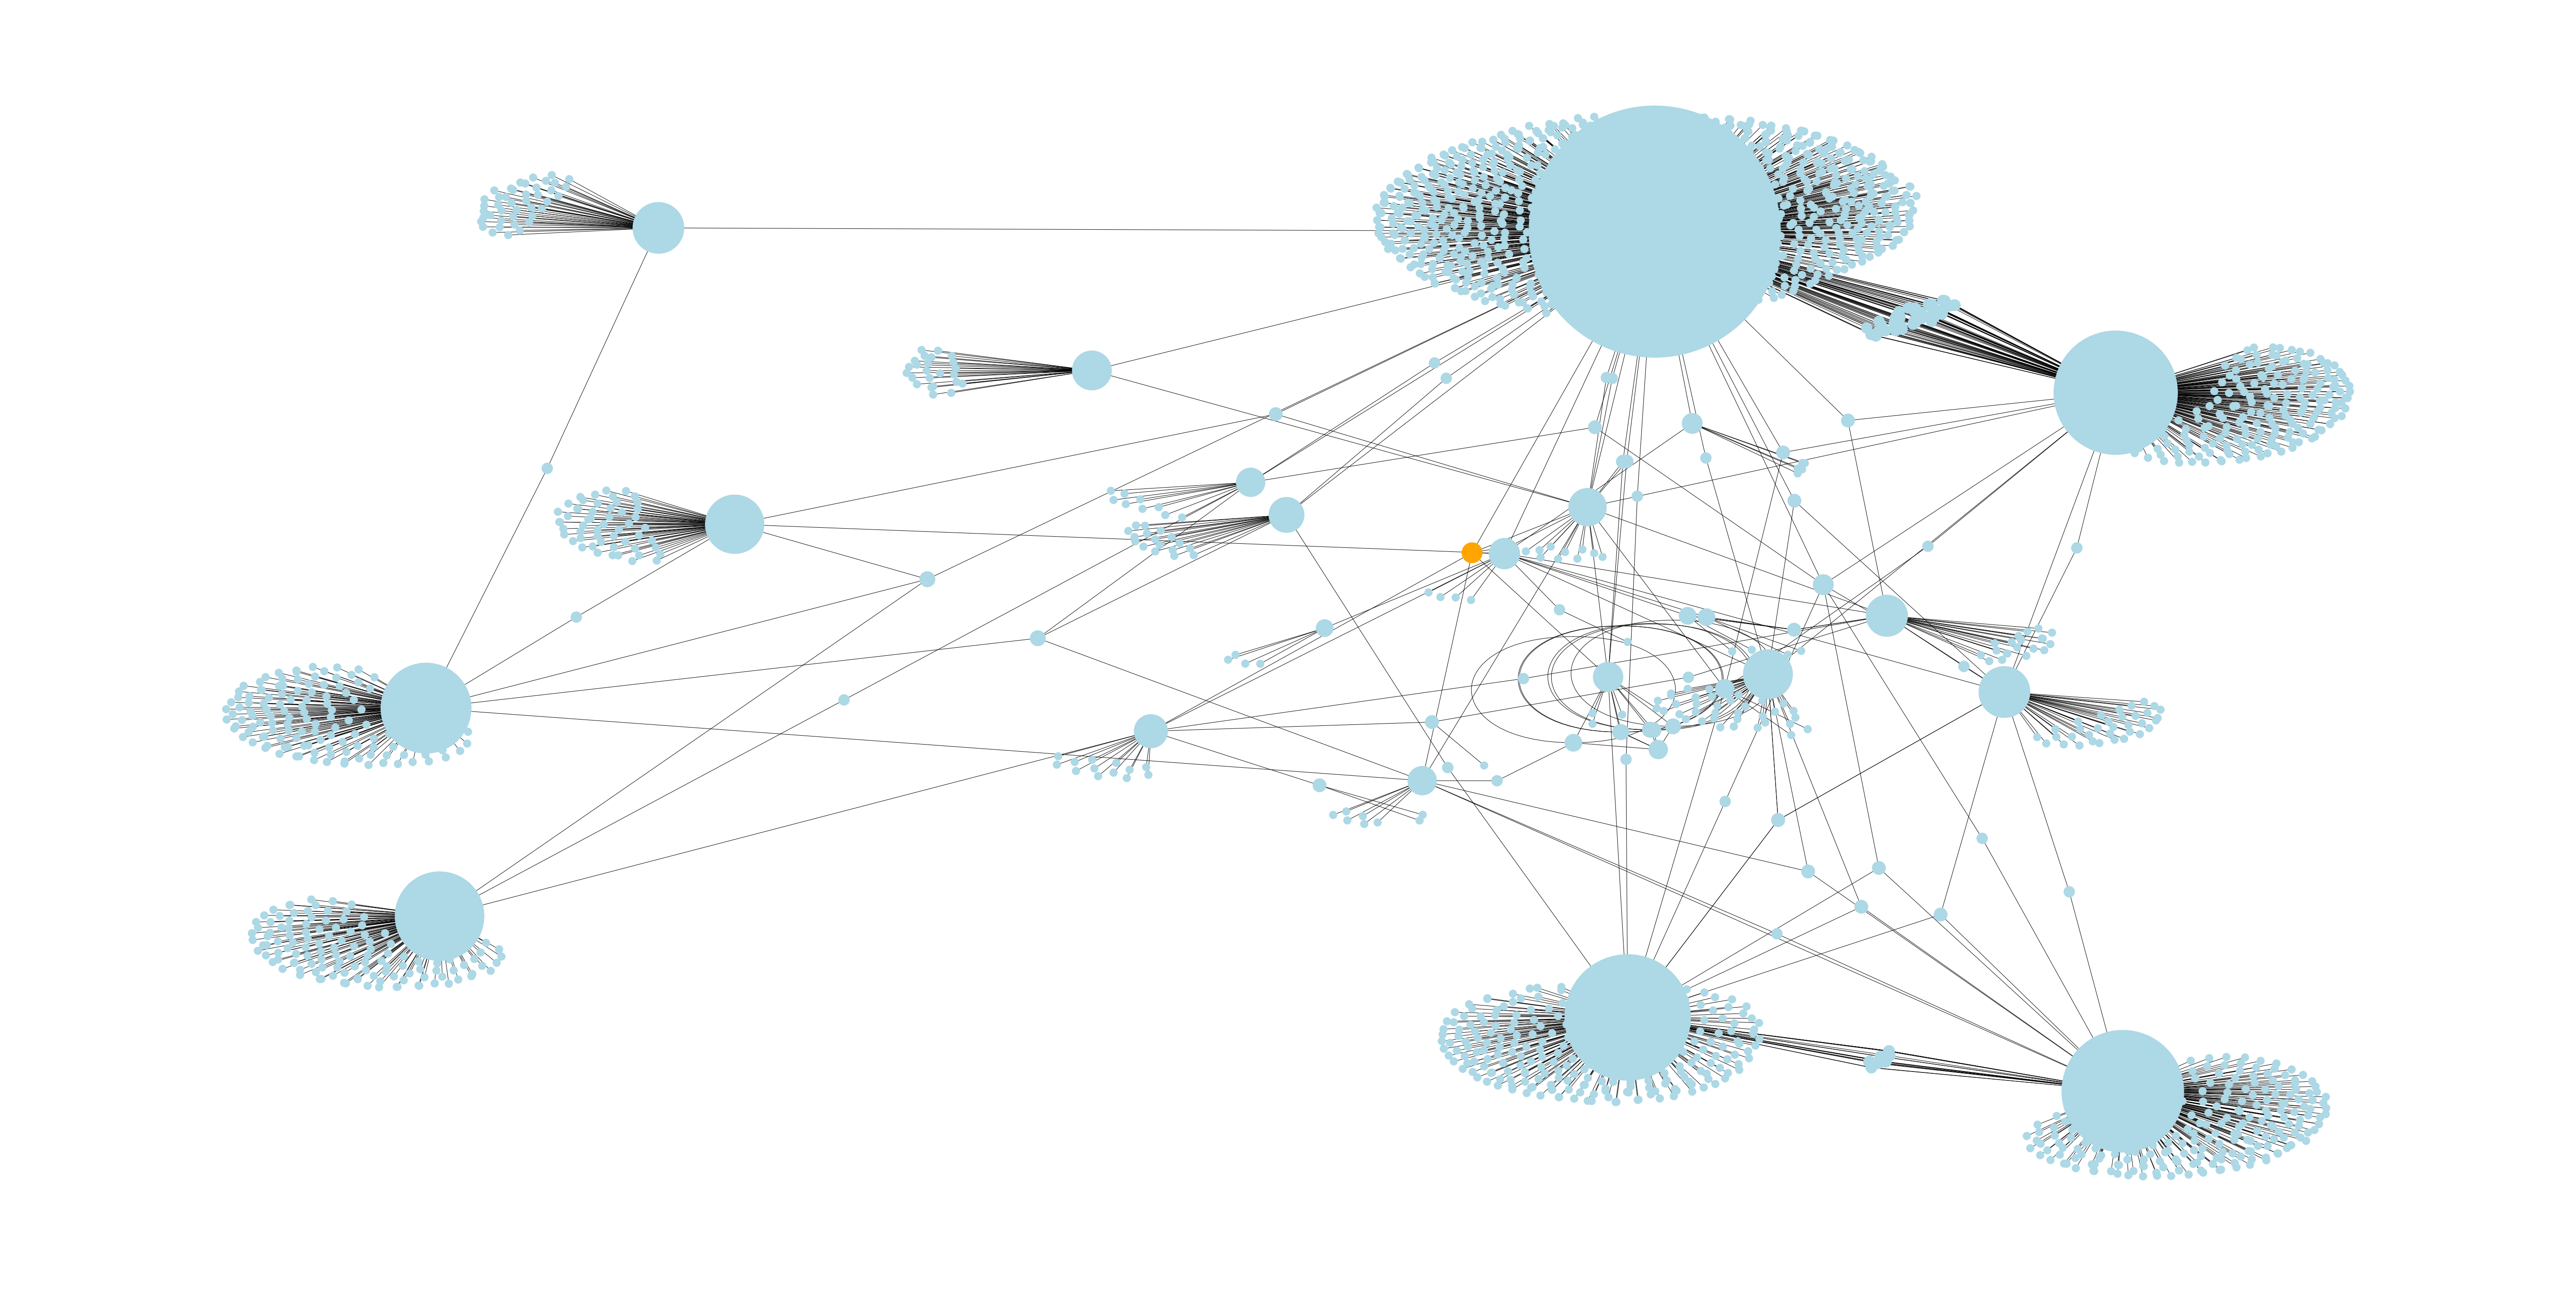

In [26]:
# Plotting the graph
fig_path = Path().cwd() / "plots" / NODE_PDF_FILE
import matplotlib.pyplot as plt

plt.figure(figsize=(80,40))
nx.draw_spring(input_node, with_labels=False, node_color=['orange' if node == NODE_URL else 'lightblue' for node in input_node], node_size=[v * 300 for v in dict(input_node.degree()).values()])
if not fig_path.is_file():
    plt.savefig(fig_path)

In [27]:
neighbor_degree_dict = sort_neighborhood_degree(sorted_nodes_by_degree, input_node)

In [28]:
similarity_temp_graph_iceberg = iceberg_pruning(permutations(sorted_nodes_by_degree), input_node, neighbor_degree_dict)

116220  nodes were pruned by rule 1.
1898012  nodes were pruned by rule 2.
645886  nodes were pruned by rule 3.


In [29]:
aux, nodes = auxiliary(input_node, similarity_temp_graph_iceberg)

In [30]:
if similarity_temp_graph_iceberg.has_node(NODE_URL):
    r_sim = rolesim(nx.Graph(aux), sorted(nodes), neighbor_degree_dict)

In [31]:
rolesim_df = nx.to_pandas_edgelist(r_sim)
rolesim_df = rolesim_df.drop(rolesim_df[(rolesim_df.weight <= BETA) | (rolesim_df.source != NODE_URL)].index)
rolesim_df.drop("source", axis=1, inplace=True)
rolesim_df.rename(columns = {'target':'node'}, inplace = True)
rolesim_df.sort_values(by=["weight"], ascending=False)

,node,weight
103,http://www.wikidata.org/entity/Q70437423,0.715800
25,https://d-nb.info/gnd/4329763-8,0.696200
109,http://www.wikidata.org/entity/Q1588477,0.696200
108,http://www.wikidata.org/entity/Q87473209,0.696200
107,http://www.wikidata.org/entity/Q25383099,0.696200
106,http://www.wikidata.org/entity/Q69429678,0.696200
104,http://www.wikidata.org/entity/Q1414436,0.696200
27,http://www.wikidata.org/entity/Q69429606,0.696200
1349,http://g.co/kg/g/11c3w4hdv0,0.676600
26,http://www.wikidata.org/value/b378b58509390864...,0.598200


# Final Results

In [32]:
for index, row in rolesim_df.iterrows():
    df.loc[df.node == row['node'], 'rolesim'] = row['weight']

df['score'] = df.apply(lambda row: row.identifier if row.identifier == 1 else (0.5*row.rolesim + 0.5*row.neighborhood), axis=1)
df.sort_values(by=["score"], ascending=False)

,node,identifier,rolesim,neighborhood,score
1237,http://www.wikidata.org/entity/Q336938,1,0.0000,0.148148,1.000000
1602,http://www.wikidata.org/entity/Q70437423,0,0.7158,0.111111,0.413456
1065,http://www.wikidata.org/entity/Q25383099,0,0.6962,0.125000,0.410600
684,http://www.wikidata.org/entity/Q1588477,0,0.6962,0.125000,0.410600
2314,https://d-nb.info/gnd/4329763-8,0,0.6962,0.125000,0.410600
...,...,...,...,...,...
970,http://www.wikidata.org/entity/Q2202679,0,0.0000,0.000000,0.000000
966,http://www.wikidata.org/entity/Q217208,0,0.0000,0.000000,0.000000
965,http://www.wikidata.org/entity/Q21719454,0,0.0000,0.000000,0.000000
963,http://www.wikidata.org/entity/Q21657448,0,0.0000,0.000000,0.000000


In [33]:
result_path = Path().cwd() / "results" / NODE_HTML_FILE
if not result_path.is_file():
    df.loc[df.score > 0].sort_values(by=["score"], ascending=False).to_html(result_path)

# Computing RoleSim and Neighborhood correlation

In [50]:
from scipy.stats.stats import pearsonr

df1 = pd.read_html(Path.cwd() / "results" / "Q1345732.html", header=0, index_col=0)[0]
df2 = pd.read_html(Path.cwd() / "results" / "Q13364705.html", header=0, index_col=0)[0]
df3 = pd.read_html(Path.cwd() / "results" / "Q14786283.html", header=0, index_col=0)[0]
df4 = pd.read_html(Path.cwd() / "results" / "Q15149637.html", header=0, index_col=0)[0]
df5 = pd.read_html(Path.cwd() / "results" / "Q108599713.html", header=0, index_col=0)[0]

frames = [df1, df2, df3, df4, df5]
result = pd.concat(frames)

cor = pearsonr(result['rolesim'], result['neighborhood'])
print(f"r = {cor[0]} and p = {cor[1]}")

r = -0.5094843707272413 and p = 4.103109710948194e-152
